# 잠재요인 협업 필터링

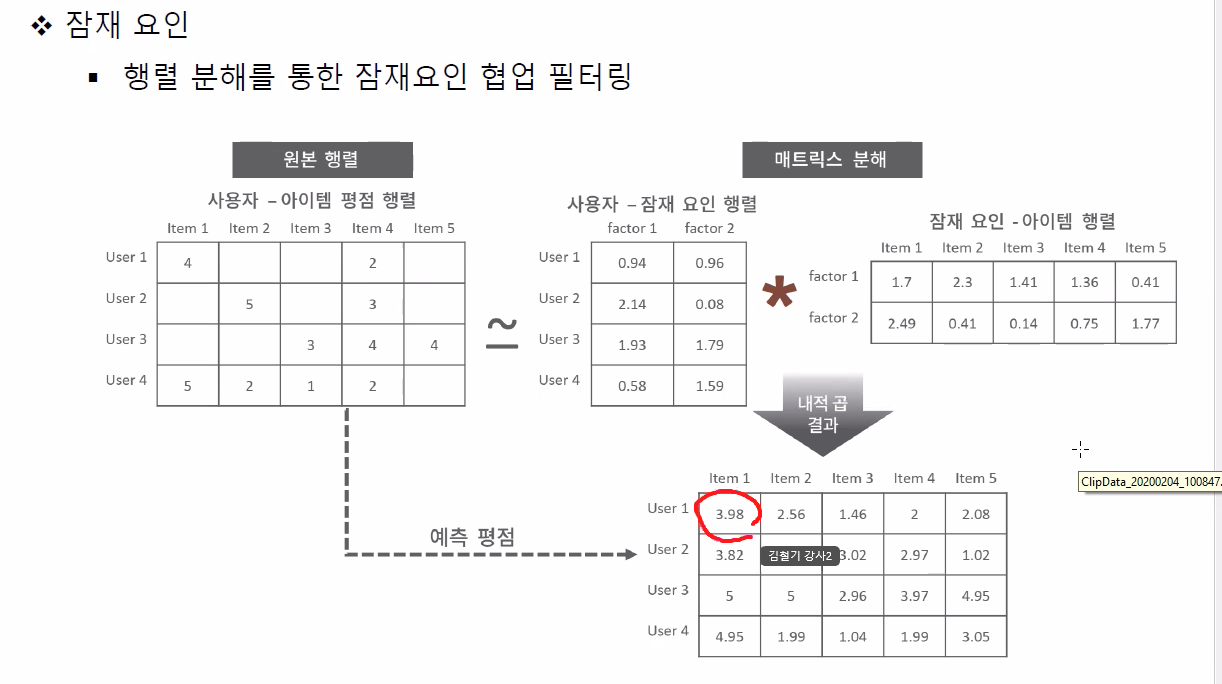

In [2]:
import pandas as pd
from google.colab import files
up = files.upload()

Saving movies.csv to movies.csv
Saving ratings.csv to ratings.csv
Saving ratings_noh.csv to ratings_noh.csv
Saving tags.csv to tags.csv


In [3]:
up.keys()

dict_keys(['movies.csv', 'ratings.csv', 'ratings_noh.csv', 'tags.csv'])

In [6]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
ratings.userId.nunique(), ratings.movieId.nunique()

(610, 9724)

In [10]:
!pip install scikit-surprise > /dev/null

In [11]:
from surprise import SVD, Reader
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format = "user item rating timestamp", sep = ",", rating_scale = (0.5,5))
data_folds = DatasetAutoFolds("ratings_noh.csv", reader = reader)

In [12]:
# 전체 데이터를 학습 데이터로 사용
trainset = data_folds.build_full_trainset()

In [16]:
# 모델 생성 및 학습
model = SVD(n_epochs = 20, n_factors = 50, random_state=2022)
model.fit(trainset)

- 사용자Id: 9, 영화ID : 42 (Dead President (1995))

In [23]:
# 영화 정보
mdf = pd.read_csv("movies.csv")
mdf.head(45).tail(5)

,movieId,title,genres
40,44,Mortal Kombat (1995),Action|Adventure|Fantasy
41,45,To Die For (1995),Comedy|Drama|Thriller
42,46,How to Make an American Quilt (1995),Drama|Romance
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
44,48,Pocahontas (1995),Animation|Children|Drama|Musical|Romance


In [24]:
# 사용자 9번이 42번 영화를 봤는지 확인
movieIds = ratings[ratings.userId == 9]["movieId"]
movieIds[movieIds ==42].count()

0

In [27]:
# 사용자 9번의 42번 영화에 대한 예상 평점
uid,mid = str(9), str(42)
pred = model.predict(uid, mid, verbose = True)

user: 9          item: 42         r_ui = None   est = 3.25   {'was_impossible': False}


In [28]:
pred

Prediction(uid='9', iid='42', r_ui=None, est=3.249924377339538, details={'was_impossible': False})

- 사용자 9번이 보지 않은 영화중에서 예상 점수가 가장 높은 Top 10

In [33]:
seen_movies = ratings[ratings.userId == 9]["movieId"].tolist()
total_movies = mdf.movieId.tolist()
unseen_movies = [movie for movie in total_movies if movie not in seen_movies]
len(unseen_movies), len(seen_movies)

(9696, 46)

In [40]:
predictions = [model.predict(uid, str(mid)) for mid in unseen_movies]

In [41]:
predictions[:5]

[Prediction(uid='9', iid='1', r_ui=None, est=3.702922347424712, details={'was_impossible': False}),
 Prediction(uid='9', iid='2', r_ui=None, est=3.2274451421980412, details={'was_impossible': False}),
 Prediction(uid='9', iid='3', r_ui=None, est=3.0342513115122123, details={'was_impossible': False}),
 Prediction(uid='9', iid='4', r_ui=None, est=2.661778597408914, details={'was_impossible': False}),
 Prediction(uid='9', iid='5', r_ui=None, est=2.689490348191407, details={'was_impossible': False})]

In [42]:
def sortkey_est(pred):
    return pred.est

In [43]:
predictions.sort(key = sortkey_est, reverse = True)

In [44]:
predictions[:5]

[Prediction(uid='9', iid='318', r_ui=None, est=4.070330794979969, details={'was_impossible': False}),
 Prediction(uid='9', iid='1217', r_ui=None, est=4.063731956995097, details={'was_impossible': False}),
 Prediction(uid='9', iid='1261', r_ui=None, est=4.051908410348554, details={'was_impossible': False}),
 Prediction(uid='9', iid='1204', r_ui=None, est=4.0227662213503805, details={'was_impossible': False}),
 Prediction(uid='9', iid='3275', r_ui=None, est=4.011500870494226, details={'was_impossible': False})]

In [49]:
top_movie_ids = [int(pred.iid) for pred in predictions[:10]]
top_movie_ratings = [pred.est for pred in predictions[:10]]
top_movie_titles = mdf[mdf.movieId.isin(top_movie_ids)]["title"]
top_movie_titles

46                             Usual Suspects, The (1995)
277                      Shawshank Redemption, The (1994)
680                        Philadelphia Story, The (1940)
906                             Lawrence of Arabia (1962)
918                                            Ran (1985)
960                    Evil Dead II (Dead by Dawn) (1987)
1258                                 Boogie Nights (1997)
2462                          Boondock Saints, The (2000)
3622    Amelie (Fabuleux destin d'Amélie Poulain, Le) ...
9071                                     Spotlight (2015)
Name: title, dtype: object

In [51]:
top_df = pd.DataFrame({
    "영화명" : top_movie_titles,
    "예상평점" : top_movie_ratings,
})
top_df.index.name = "movieId"
top_df

,영화명,예상평점
movieId,,
46,"Usual Suspects, The (1995)",4.070331
277,"Shawshank Redemption, The (1994)",4.063732
680,"Philadelphia Story, The (1940)",4.051908
906,Lawrence of Arabia (1962),4.022766
918,Ran (1985),4.011501
960,Evil Dead II (Dead by Dawn) (1987),3.999696
1258,Boogie Nights (1997),3.985348
2462,"Boondock Saints, The (2000)",3.979885
3622,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",3.978625
